In [1]:
# import cv2
# from PIL import Image
# from matplotlib import pyplot as plt
# import numpy as np
# from glass.inference.glass_runner import GlassRunner
# from glass.utils.logger import setup_logger
# from glass.utils.visualizer import visualize
# from matplotlib import pyplot as plt
# from paddleocr import PaddleOCR, draw_ocr
# import pandas as pd

# logger = setup_logger()

In [2]:
import os
import cv2
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

# Load, Extract, Transform data

In [3]:
TEST_DATA_DIR = "data/test_data/"
TEST_GT_DIR = TEST_DATA_DIR + "test_gt"
TEST_IMG_DIR = TEST_DATA_DIR + "Images"
NUM_FILES = 3

In [4]:
def get_file_names_from_folder(folder_path, num_files):
    files = os.listdir(folder_path)
    files = [f for f in files if os.path.isfile(os.path.join(folder_path, f))]
    files = sorted(files)
    return files[:num_files]


def get_ground_truths(dir, file_names):
    columns = ['x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'x4', 'y4', 'script', 'text']
    GTs = []
    for file_name in file_names:
        print(f"extracting {dir}/{file_name}")
        # get round truth as dataframe
        df = pd.read_csv(dir+'/'+file_name, delimiter=',', names=columns)
        
        # get df in format for evaluation
        gt = []
        for _, item in df.iterrows():
            gt.append(([[item.x1, item.y1], [item.x2, item.y2], [item.x3, item.y3], [item.x4, item.y4]], item.text))
            
        GTs.append(gt)
    return GTs


def get_images(dir, file_names):
    images = []
    print()
    for file_name in file_names:
        print(f"extracting {dir}/{file_name}")
        image = np.asarray(Image.open(dir+'/'+ file_name).convert('RGB')) # Inference is not supported for images with alpha channel
        images.append(image)
    return images


In [5]:
gt_filenames = get_file_names_from_folder(TEST_GT_DIR, num_files=NUM_FILES)
img_filenames = get_file_names_from_folder(TEST_IMG_DIR, num_files=NUM_FILES)

In [6]:
GTs = get_ground_truths(TEST_GT_DIR, gt_filenames)
images = get_images(TEST_IMG_DIR, img_filenames)

extracting data/test_data/test_gt/tr_img_01001.txt
extracting data/test_data/test_gt/tr_img_01002.txt
extracting data/test_data/test_gt/tr_img_01003.txt

extracting data/test_data/Images/tr_img_01001.jpg
extracting data/test_data/Images/tr_img_01002.jpg
extracting data/test_data/Images/tr_img_01003.jpg


In [7]:
len(GTs), len(images)

(3, 3)

In [8]:
GTs

[[([[559, 1207], [2830, 1235], [2821, 1662], [548, 1622]], 'TICKETS')],
 [([[945, 1], [1268, 0], [1268, 43], [945, 43]], '#5TimesLonger'),
  ([[1182, 81], [1222, 80], [1221, 91], [1181, 92]], 'london'),
  ([[1222, 80], [1270, 80], [1270, 90], [1222, 91]], 'stansted'),
  ([[1182, 91], [1214, 91], [1214, 103], [1182, 103]], 'airport'),
  ([[601, 814], [1619, 837], [1601, 939], [609, 896]], '#5TimesLonger')],
 [([[1222, 1147], [1241, 1151], [1240, 1159], [1223, 1160]], 'Lanc'),
  ([[1535, 1118], [1552, 1117], [1553, 1128], [1538, 1129]], 'Hotel'),
  ([[673, 358], [758, 393], [753, 419], [678, 390]], '600'),
  ([[399, 302], [691, 425], [683, 472], [406, 373]], 'Texas'),
  ([[267, 1155], [287, 1156], [288, 1166], [267, 1166]], 'ONE'),
  ([[490, 296], [630, 351], [621, 366], [487, 314]], 'DISTRICT'),
  ([[473, 250], [644, 307], [638, 341], [484, 279]], 'THEATER'),
  ([[1189, 1147], [1222, 1150], [1223, 1163], [1189, 1162]], 'Bistro'),
  ([[265, 1165], [287, 1165], [287, 1174], [264, 1174]], 

In [9]:
def clean_data(GTs):
    return [[pred for pred in image if pred[1]!="###"] for image in GTs]
GTs=clean_data(GTs)

# Get inference results

## Load models

### Glass

In [10]:
from glass.inference.glass_runner import GlassRunner
from glass.utils.logger import setup_logger
from glass.utils.visualizer import visualize

In [11]:
#download model
#!wget 'https://glass-text-spotting.s3.eu-west-1.amazonaws.com/models/glass_250k_full_textocr_finetune.pth' -O 'pretrained_models/glass_textocr.pth'

In [12]:
model_path = './pretrained_models/glass_textocr.pth'
config_path = './configs/glass_finetune_textocr.yaml'
glass_runner = GlassRunner(model_path=model_path, config_path=config_path, post_process=True)

### Paddle OCR

In [13]:
from paddleocr import PaddleOCR, draw_ocr

In [14]:
ocr = PaddleOCR(use_angle_cls=True, lang='en')

[2024/06/04 08:20:13] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/home/fatcat/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/home/fatcat/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25, rec_ch

## Perform Inference

In [15]:
glass_results = []
for img in images:
    glass_preds = glass_runner(img)
    glass_results.append(glass_preds)


In [16]:
paddleocr_results = []
for img in images:
    paddle_pred = ocr.ocr(img, cls=True)
    paddleocr_results.append(paddle_pred)

[2024/06/04 08:23:51] ppocr DEBUG: dt_boxes num : 1, elapsed : 1.3868937492370605
[2024/06/04 08:23:51] ppocr DEBUG: cls num  : 1, elapsed : 0.04256582260131836
[2024/06/04 08:23:51] ppocr DEBUG: rec_res num  : 1, elapsed : 0.23421382904052734
[2024/06/04 08:23:53] ppocr DEBUG: dt_boxes num : 2, elapsed : 1.619910478591919
[2024/06/04 08:23:53] ppocr DEBUG: cls num  : 2, elapsed : 0.06280231475830078
[2024/06/04 08:23:54] ppocr DEBUG: rec_res num  : 2, elapsed : 0.8253505229949951
[2024/06/04 08:23:55] ppocr DEBUG: dt_boxes num : 3, elapsed : 1.5550198554992676
[2024/06/04 08:23:56] ppocr DEBUG: cls num  : 3, elapsed : 0.08275938034057617
[2024/06/04 08:23:56] ppocr DEBUG: rec_res num  : 3, elapsed : 0.7841088771820068


## Post processing


In [17]:
GTs[2]

[([[1222, 1147], [1241, 1151], [1240, 1159], [1223, 1160]], 'Lanc'),
 ([[1535, 1118], [1552, 1117], [1553, 1128], [1538, 1129]], 'Hotel'),
 ([[673, 358], [758, 393], [753, 419], [678, 390]], '600'),
 ([[399, 302], [691, 425], [683, 472], [406, 373]], 'Texas'),
 ([[267, 1155], [287, 1156], [288, 1166], [267, 1166]], 'ONE'),
 ([[490, 296], [630, 351], [621, 366], [487, 314]], 'DISTRICT'),
 ([[473, 250], [644, 307], [638, 341], [484, 279]], 'THEATER'),
 ([[1189, 1147], [1222, 1150], [1223, 1163], [1189, 1162]], 'Bistro'),
 ([[265, 1165], [287, 1165], [287, 1174], [264, 1174]], 'WAY'),
 ([[1455, 1122], [1477, 1120], [1478, 1132], [1457, 1135]], 'Hotel'),
 ([[899, 1170], [918, 1169], [920, 1181], [901, 1183]], 'otel')]

### Glass

In [18]:
# glass_results[0]

In [19]:
from glass.evaluation.text_evaluator import get_instances_text

glass_preds = []

for preds in glass_results:
    glass_texts, glass_text_scores, _ = get_instances_text(preds.pred_text_prob, text_encoder=glass_runner.text_encoder)
    glass_bb_texts_pairs = []
    
    for item in zip(preds.pred_polygons.tolist(),glass_texts):
        glass_bb_texts_pairs.append(item)
    
    glass_preds.append(glass_bb_texts_pairs)

### PaddleOCR

In [20]:
paddleocr_results[0]

[[[[[582.0, 1205.0], [2820.0, 1240.0], [2814.0, 1647.0], [576.0, 1612.0]],
   ('TICKETS', 0.9954368472099304)]]]

In [21]:
paddle_preds= []
for results in paddleocr_results:
    # print("*************",results)
    paddle_texts=[]
    for pred in results[0]:
        # print("#######",pred)
        paddle_texts.append((pred[0], pred[1][0]))
    paddle_preds.append(paddle_texts)


In [22]:
len(paddle_preds)

3

## Visulaization

In [23]:
id=2
figure = visualize(preds=glass_results[id], image=images[id], text_encoder=glass_runner.text_encoder, vis_width=720, vis_text=True)
figure.show()

data/test_data/Images/tr_img_01003.jpg
[[[[490.0, 281.0], [639.0, 342.0], [624.0, 378.0], [476.0, 318.0]], ('DISTRICT', 0.9944802522659302)], [[[408.0, 300.0], [702.0, 424.0], [674.0, 491.0], [380.0, 367.0]], ('Texas', 0.9962266683578491)], [[[680.0, 359.0], [765.0, 389.0], [754.0, 422.0], [668.0, 393.0]], ('600', 0.9982598423957825)]]


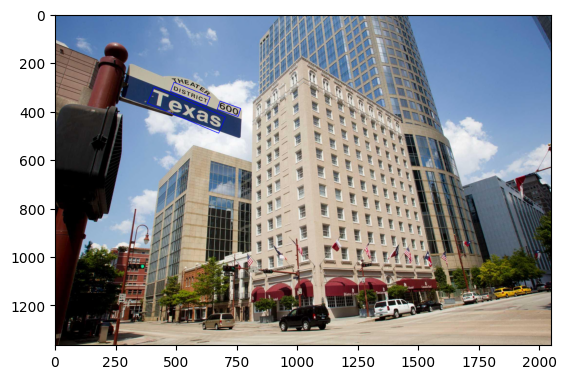

In [24]:
id = 2


file_path = TEST_IMG_DIR +'/'+ img_filenames[id]
print(file_path)

def read_image(file_path):
    image = np.asarray(Image.open(file_path).convert('RGB'))
    return image

img = read_image(file_path)
img_cv2 = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

for line in paddleocr_results[id]:
    print(line)

# Draw the results on the image
boxes = [elements[0] for elements in line]
image = draw_ocr(img_cv2, boxes)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

# Evaluate models

## loss functions

In [25]:
import numpy as np
from shapely.geometry import Polygon
from scipy.optimize import linear_sum_assignment

def iou(boxA, boxB):
    polyA = Polygon(boxA)
    polyB = Polygon(boxB)
    if not polyA.is_valid or not polyB.is_valid:
        return 0.0
    inter_area = polyA.intersection(polyB).area
    union_area = polyA.area + polyB.area - inter_area
    return inter_area / union_area

def levenshtein_distance(s1, s2):
    if len(s1) < len(s2):
        return levenshtein_distance(s2, s1)
    if len(s2) == 0:
        return len(s1)
    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1
            deletions = current_row[j] + 1
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row
    return previous_row[-1]

def cer(s1, s2):
    return levenshtein_distance(s1, s2) / len(s2)

def wer(s1, s2):
    s1_words = s1.split()
    s2_words = s2.split()
    return levenshtein_distance(s1_words, s2_words) / len(s2_words)

def calculate_cost_matrix(predictions, ground_truths):
    cost_matrix = np.zeros((len(predictions), len(ground_truths)))
    for i, pred in enumerate(predictions):
        for j, gt in enumerate(ground_truths):
            iou_score = iou(pred[0], gt[0])
            text_distance = levenshtein_distance(pred[1], gt[1])
            cost_matrix[i, j] = 1 - iou_score + text_distance  # Có thể điều chỉnh trọng số của IoU và text distance
    return cost_matrix

def calculate_text_cost_matrix(predictions, ground_truths):
    cost_matrix = np.zeros((len(predictions), len(ground_truths)))
    for i, pred in enumerate(predictions):
        for j, gt in enumerate(ground_truths):
            text_distance = levenshtein_distance(pred[1], gt[1])
            cost_matrix[i, j] = text_distance
    return cost_matrix

def precision_recall_f1(predictions, ground_truths, iou_threshold=0.5):
    cost_matrix = calculate_cost_matrix(predictions, ground_truths)
    row_ind, col_ind = linear_sum_assignment(cost_matrix)

    true_positives = 0
    false_positives = len(predictions)
    false_negatives = len(ground_truths)

    for i, j in zip(row_ind, col_ind):
        if iou(predictions[i][0], ground_truths[j][0]) >= iou_threshold:
            true_positives += 1
            false_positives -= 1
            false_negatives -= 1

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f1_score

def precision_recall_f1_text(predictions, ground_truths, distance_threshold=0):
    cost_matrix = calculate_text_cost_matrix(predictions, ground_truths)
    row_ind, col_ind = linear_sum_assignment(cost_matrix)

    true_positives = 0
    false_positives = len(predictions)
    false_negatives = len(ground_truths)

    for i, j in zip(row_ind, col_ind):
        if levenshtein_distance(predictions[i][1], ground_truths[j][1]) <= distance_threshold:
            true_positives += 1
            false_positives -= 1
            false_negatives -= 1

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f1_score

In [26]:
def avg_metric(GTs, Preds):
    # Initialize cumulative metric sums
    avg_iou_precision = avg_iou_recall = avg_iou_f1 = 0
    avg_text_precision = avg_text_recall = avg_text_f1 = 0
    avg_cer = avg_wer = 0
    text_count = 0
    
    # Iterate over each pair of ground truths and predictions
    for gt, pred in zip(GTs, Preds):
        # Calculate the cost matrix and solve the assignment problem
        cost_matrix = calculate_cost_matrix(pred, gt)
        row_ind, col_ind = linear_sum_assignment(cost_matrix)
        
        # Iterate over matched pairs (pred, gt)
        for i, j in zip(row_ind, col_ind):
            pred_box, pred_text = pred[i]  # Access prediction pair correctly
            gt_box, gt_text = gt[j]
            text_count += 1
            avg_cer += cer(pred_text, gt_text)
            avg_wer += wer(pred_text, gt_text)
    
        # Calculate IOU precision, recall, and F1 for current pair
        iou_precision, iou_recall, iou_f1 = precision_recall_f1(pred, gt)
        avg_iou_precision += iou_precision
        avg_iou_recall += iou_recall
        avg_iou_f1 += iou_f1
        
        # Calculate text precision, recall, and F1 for current pair
        text_precision, text_recall, text_f1 = precision_recall_f1_text(pred, gt)
        avg_text_precision += text_precision
        avg_text_recall += text_recall
        avg_text_f1 += text_f1
    
    t = len(Preds)
    if text_count > 0:
        avg_cer /= text_count
        avg_wer /= text_count
    else:
        avg_cer = avg_wer = float('nan')  # Handle zero text count case
    
    return (avg_cer, avg_wer,
            avg_iou_precision / t if t > 0 else float('nan'),
            avg_iou_recall / t if t > 0 else float('nan'),
            avg_iou_f1 / t if t > 0 else float('nan'),
            avg_text_precision / t if t > 0 else float('nan'),
            avg_text_recall / t if t > 0 else float('nan'),
            avg_text_f1 / t if t > 0 else float('nan'))


In [27]:
# cost_matrix = calculate_cost_matrix(glass_bb_texts_pairs, gt)
# row_ind, col_ind = linear_sum_assignment(cost_matrix)

# # In các cặp ghép
# for i, j in zip(row_ind, col_ind):
#     pred_box, pred_text = glass_bb_texts_pairs[i]
#     gt_box, gt_text = gt[j]
#     print(f"Prediction: Box={pred_box}, Text={pred_text}")
#     print(f"Ground Truth: Box={gt_box}, Text={gt_text}")
#     print(f"IoU: {iou(pred_box, gt_box)}, CER: {cer(pred_text, gt_text)}, WER: {wer(pred_text, gt_text)}")
#     print()

# precision, recall, f1 = precision_recall_f1(glass_bb_texts_pairs, gt)
# print(f"Precision: {precision:.2f}")
# print(f"Recall: {recall:.2f}")
# print(f"F1 Score: {f1:.2f}")

# precision, recall, f1 = precision_recall_f1_text(glass_bb_texts_pairs, gt)
# print(f"Text Precision: {precision:.2f}")
# print(f"Text Recall: {recall:.2f}")
# print(f"Text F1 Score: {f1:.2f}")

## Compare results

In [28]:
g_cer, g_wer, g_ioup, g_iour, g_iouf1, g_tp, g_tr, g_tf1 = avg_metric(GTs, glass_preds)
g_cer, g_wer, g_ioup, g_iour, g_iouf1, g_tp, g_tr, g_tf1

(0.025641025641025644,
 0.16666666666666666,
 1.0,
 0.8484848484848485,
 0.9019607843137255,
 0.8666666666666667,
 0.7151515151515152,
 0.7686274509803921)

In [29]:
p_cer, p_wer, p_ioup, p_iour, p_iouf1, p_tp, p_tr, p_tf1 = avg_metric(GTs, paddle_preds)
p_cer, p_wer, p_ioup, p_iour, p_iouf1, p_tp, p_tr, p_tf1

(0.0,
 0.0,
 0.8888888888888888,
 0.5272727272727272,
 0.6190476190476192,
 1.0,
 0.5575757575757575,
 0.6666666666666666)

# Tracking with MLflow

In [ ]:
# !mlflow ui --backend-store-uri sqlite:///mlflow.db

In [31]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("Models Comparision")

2024/06/04 08:28:23 INFO mlflow.tracking.fluent: Experiment with name 'Models Comparision' does not exist. Creating a new experiment.


<Experiment: artifact_location='/home/fatcat/Project/Experiments/mlruns/2', creation_time=1717489703538, experiment_id='2', last_update_time=1717489703538, lifecycle_stage='active', name='Models Comparision', tags={}>

In [33]:
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("temp experiemnts")

<Experiment: artifact_location='/home/fatcat/Project/Experiments/mlruns/3', creation_time=1717504383188, experiment_id='3', last_update_time=1717504383188, lifecycle_stage='active', name='temp experiemnts', tags={}>

In [ ]:
with mlflow.start_run() as run:
    
    glass_results = []
    for img in images:
        glass_preds = glass_runner(img)
        glass_results.append(glass_preds)
        
    glass_preds = []

    for preds in glass_results:
        glass_texts, glass_text_scores, _ = get_instances_text(preds.pred_text_prob, text_encoder=glass_runner.text_encoder)
        glass_bb_texts_pairs = []
        
        for item in zip(preds.pred_polygons.tolist(),glass_texts):
            glass_bb_texts_pairs.append(item)
        
        glass_preds.append(glass_bb_texts_pairs)
        
    g_cer, g_wer, g_ioup, g_iour, g_iouf1, g_tp, g_tr, g_tf1 = avg_metric(GTs, glass_preds)
    
    mlflow.pytorch.log_model()